In [1]:
# Basic packages.
import pandas as pd
import numpy as np
import tensorflow as tf
import keras_tuner as kt
tf.config.run_functions_eagerly(True)

# Visualization packages.
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Necessary variables for file exploration.
DATA_DIR = 'data'
TRANSFORMED_DIR = 'transformed'
feature_file = 'transformed_features.csv'
response_file = 'transformed_responses.csv'

# Read in the data.
feature_df = pd.read_csv('../{}/{}/{}'.format(DATA_DIR, TRANSFORMED_DIR, feature_file))
response_df = pd.read_csv('../{}/{}/{}'.format(DATA_DIR, TRANSFORMED_DIR, response_file))
feature_df.shape, response_df.shape

# Convert date to str & set as index.
feature_df['DATE'] = pd.to_datetime(feature_df['DATE'])
feature_df.set_index('DATE', drop=True, inplace=True)
response_df['Date'] = pd.to_datetime(response_df['Date'])
response_df.set_index('Date', drop=True, inplace=True)

# Normalize data frame.
normalized_df = (feature_df - feature_df.mean()) / feature_df.std()

In [3]:
# Perform a train-test split. Looking at the above data, let's train on all data prior to end of year 2005.
# Test on all data from 2005 to end of year 2019
# Keep beginning of 2020 through 2021 seperate for analysis and comparisons with other methods.
dates = np.array(feature_df.index)
# Add 1 to include December as a part of the train.
training_ends = np.where(dates == pd.to_datetime("2009-12-01"))[0][0] + 1
test_ends = np.where(dates == pd.to_datetime("2019-12-01"))[0][0] + 1
X_train, X_test, X_analysis = feature_df.iloc[:training_ends, :], feature_df.iloc[training_ends:test_ends, :], feature_df.iloc[test_ends:, :]
y_train, y_test, y_analysis = response_df.iloc[:training_ends, :], response_df.iloc[training_ends:test_ends, :], response_df.iloc[test_ends:, :]
X_train.shape, X_test.shape, X_analysis.shape

((216, 58), (120, 58), (19, 58))

In [5]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

def graphHistory(history, title):
    """
    Function for graphing the training and valiedation accuracy and loss
    ...
    :param history - history object from keras desired to plot.
    :param title - str that will be the title of the resulting plot.
    """
    # summarize history for accuracy
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    axes[0].plot(history.history['accuracy'])
    axes[0].plot(history.history['val_accuracy'])
    #axes[0].title('Model Accuracy ' + title)
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(['Tr. Acc', 'Val. Acc'])

    # summarize history for loss
    axes[1].plot(history.history['loss'])
    axes[1].plot(history.history['val_loss'])
    #axes[1].title('Model Loss ' + title)
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(['Tr. Loss', 'Val. Loss'])
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [6]:
# Do the data transformations...
n_steps = 12
lstm_X_train, lstm_y_train = split_sequence(y_train.values[:, 0], n_steps)
lstm_X_test, lstm_y_test = split_sequence(y_test.values[:, 0], n_steps)
lstm_X_train.shape, lstm_y_train.shape, lstm_X_test.shape, lstm_y_test.shape

((204, 12), (204,), (108, 12), (108,))

In [13]:
# Reshape from (samples, timesteps) to (samples, timesteps, features)
n_features = 1
lstm_X_train = lstm_X_train.reshape((lstm_X_train.shape[0], lstm_X_train.shape[1], n_features))
lstm_X_test = lstm_X_test.reshape((lstm_X_test.shape[0], lstm_X_test.shape[1], n_features))

## Vanilla LSTMs

Consists of a single, hidden layer of LSTM units and an output layer to make the prediction.

In [14]:
# Define the model.
lstm = tf.keras.models.Sequential()
lstm.add(tf.keras.layers.LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
lstm.add(tf.keras.layers.Dense(1))
lstm.compile(optimizer='adam', loss='mse', metrics='accuracy')
lstm.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                10400     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
3/7 [===========>..................] - ETA: 0s - loss: 16.6526 - accuracy: 0.0000e+00

/Users/davidmottice/Documents/AFIT/principal-try-2/project-env/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


7/7 [==============================] - 0s 39ms/step - loss: 18.5586 - accuracy: 0.0000e+00 - val_loss: 6.3481 - val_accuracy: 0.0000e+00
Epoch 2/100
7/7 [==============================] - 0s 37ms/step - loss: 18.3477 - accuracy: 0.0000e+00 - val_loss: 6.4047 - val_accuracy: 0.0000e+00
Epoch 3/100
7/7 [==============================] - 0s 36ms/step - loss: 18.2121 - accuracy: 0.0000e+00 - val_loss: 6.4650 - val_accuracy: 0.0000e+00
Epoch 4/100
7/7 [==============================] - 0s 35ms/step - loss: 18.1138 - accuracy: 0.0000e+00 - val_loss: 6.5156 - val_accuracy: 0.0000e+00
Epoch 5/100
7/7 [==============================] - 0s 35ms/step - loss: 18.0166 - accuracy: 0.0000e+00 - val_loss: 6.5532 - val_accuracy: 0.0000e+00
Epoch 6/100
7/7 [==============================] - 0s 36ms/step - loss: 17.9066 - accuracy: 0.0000e+00 - val_loss: 6.5860 - val_accuracy: 0.0000e+00
Epoch 7/100
7/7 [==============================] - 0s 35ms/step - loss: 17.7723 - accuracy: 0.0000e+00 - val_loss: 6.6

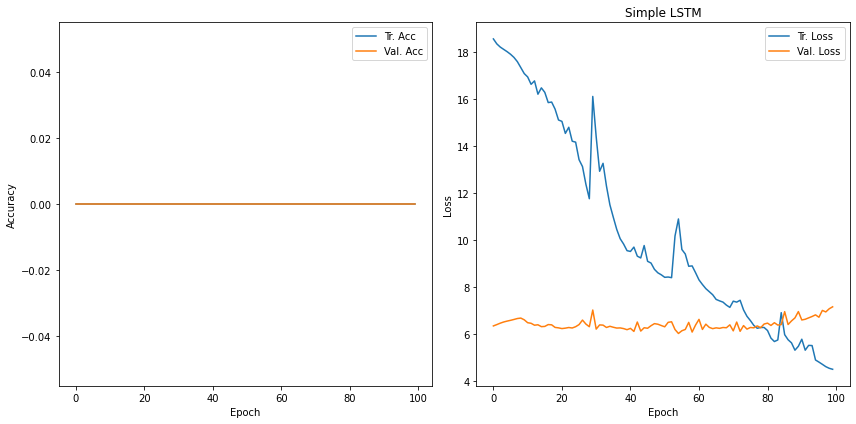

In [15]:
history = lstm.fit(lstm_X_train, lstm_y_train, epochs=100, validation_data=(lstm_X_test, lstm_y_test), shuffle=False)
graphHistory(history, 'Simple LSTM')